In [1]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, NumpyToTorch

from dqn.dqn import Agent as DQNAgent
from ddpg.ddpg import Agent as DDPGAgent
from utils.utils import preprocess_state
from utils.reward_logger import RewardLogger

# Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Q-Network

### Test on CartPole env

In [6]:
env = gym.make('CartPole-v1')
env = NumpyToTorch(env, device)
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model_type='DQN',
    name='CartPole',
    device=device,
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=1e-3,
    tau=0.005,
    lr=1e-3,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = RewardLogger()
n_episodes = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: 19.00, Epsilon: 0.95
Episode 10, Average Reward: 22.00, Epsilon: 0.80
Episode 20, Average Reward: 16.20, Epsilon: 0.68
Episode 30, Average Reward: 14.30, Epsilon: 0.59
Episode 40, Average Reward: 41.80, Epsilon: 0.39
Episode 50, Average Reward: 129.90, Epsilon: 0.11
Episode 60, Average Reward: 233.80, Epsilon: 0.01
Episode 70, Average Reward: 245.40, Epsilon: 0.01
Episode 80, Average Reward: 223.20, Epsilon: 0.01
Episode 90, Average Reward: 207.30, Epsilon: 0.01


In [7]:
# save the model
dqn_agent.save_models()

In [8]:
env = gym.make('CartPole-v1', render_mode='human')
env = NumpyToTorch(env, device)

# Load the agent with just name and device
agent = DQNAgent.load_agent('CartPole', device)

state, _ = env.reset()
done = False
total_reward = 0
while not done:
    action = agent.select_action(state, eval_mode=True)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward

print(f"Total Reward: {total_reward}")

Total Reward: 241.0


In [ ]:
# Plot the rewards
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=50)
# show_epsilon_decay(dqn_agent.epsilon_start, dqn_agent.epsilon_min, dqn_agent.epsilon_decay)

TypeError: RewardLogger.plot_rewards() missing 1 required positional argument: 'file_name'

: 

### Test on LunarLander env

In [ ]:
env = gym.make('LunarLander-v3')
env = NumpyToTorch(env, device)
# print(env.action_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model_type='DQN',
    name='LunarLander',
    device=device,
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=1e-4,
    tau=0.005,
    lr=1e-3,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = RewardLogger()
n_episodes = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: -104.24, Epsilon: 0.95
Episode 10, Average Reward: -184.62, Epsilon: 0.86
Episode 20, Average Reward: -202.91, Epsilon: 0.77
Episode 30, Average Reward: -149.61, Epsilon: 0.69
Episode 40, Average Reward: -77.81, Epsilon: 0.61
Episode 50, Average Reward: -86.22, Epsilon: 0.53
Episode 60, Average Reward: -53.21, Epsilon: 0.46
Episode 70, Average Reward: -19.99, Epsilon: 0.32
Episode 80, Average Reward: -101.05, Epsilon: 0.25
Episode 90, Average Reward: -125.85, Epsilon: 0.14


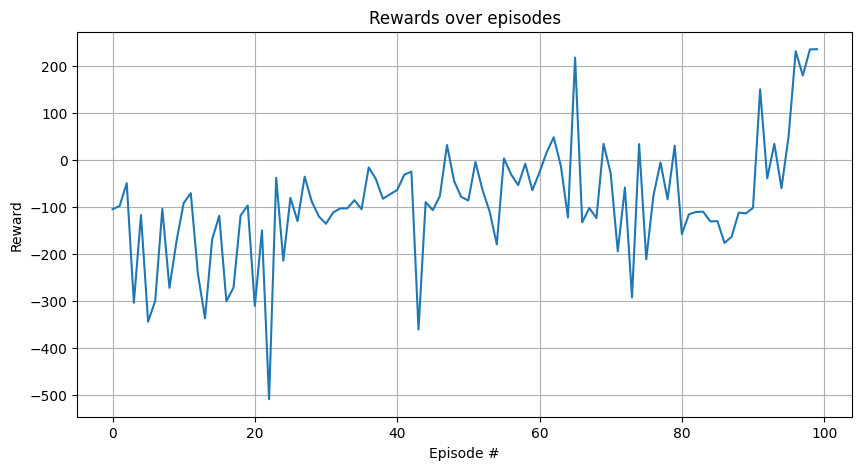

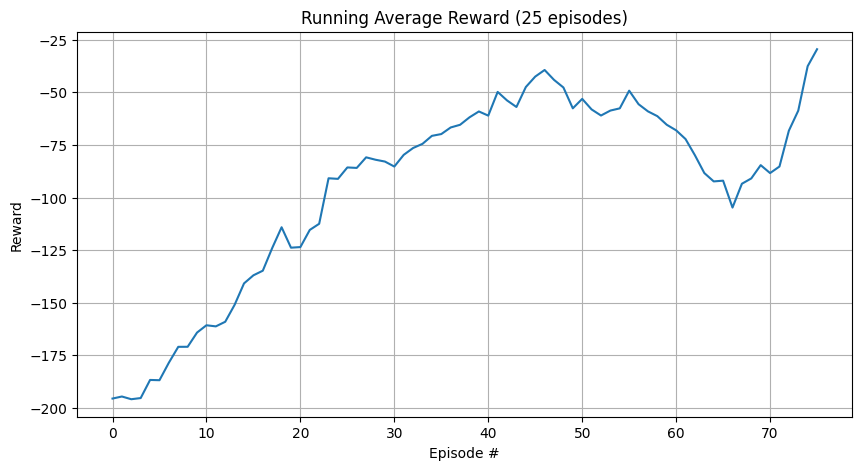

In [8]:
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=25)

### Deep Q-Netowrk with CNN architecture

In [3]:
env = gym.make('CarRacing-v3', continuous=False)
env = FrameStackObservation(env, 4)
env = NumpyToTorch(env, device)
# print(env.observation_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape
n_observations = (n_observations[1], n_observations[2], n_observations[0])  # (height, width, frames)

# print(n_actions, n_observations)
START_SKIP = 15 # to skip the nth frames at the beginning of the episode
dqn_agent = DQNAgent(
    model_type='DQN_CNN',
    name='CarRacing',
    device=device,
    batch_size=16,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.02,
    epsilon_decay=1e-5,
    tau=0.005,
    lr=1e-4,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)

rewards_storer = RewardLogger()
n_episodes = 10

for episode in range(n_episodes):
    state, _ = env.reset()
    for _ in range(START_SKIP):
        # Take random actions during the skip phase
        random_action = np.random.randint(n_actions)
        state, _, _, _, _ = env.step(random_action)
    
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Preprocess the next state
        next_state = preprocess_state(next_state)

        # Store the transition in the replay buffer
        dqn_agent.store_transition(state, action, next_state, reward, done)

        # Train the agent
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 1 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")



Episode 0, Average Reward: -61.35, Epsilon: 0.94
Episode 1, Average Reward: -64.02, Epsilon: 0.93
Episode 2, Average Reward: -60.86, Epsilon: 0.92
Episode 3, Average Reward: -60.27, Epsilon: 0.91


KeyboardInterrupt: 

In [74]:
tmp_env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=False)
tmp_env = FrameStackObservation(tmp_env, 4)
# wrap the env in the record video
env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="video", episode_trigger=lambda x: True)

state, _ = env.reset()
# Start the recorder
env.start_recording('test')

test_episodes = 5
# AI logic
for episode in range(test_episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # Reduce state and next_state to greyscale
        next_state = preprocess_state(next_state)

        state = next_state
        total_reward += reward


env.stop_recording()

# Close the environment
env.close()

c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\tfore\Desktop\INF8225_Project\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:395: UserWarning: WARN: Ignored saving a video as there were zero frames to save.
  logger.warn("Ignored saving a video as there were zero frames to save.")


# Deep Deterministic Policy Gradient (DDPG)

### Test on continous mountain car env

In [ ]:
env = gym.make('MountainCarContinuous-v0')
env = NumpyToTorch(env, device)
n_actions, n_observations = env.action_space.shape, env.observation_space.shape[0]
n_observations = (n_observations, )
print(n_actions, n_observations)


ddpg_agent = DDPGAgent(
    model_type='DDPG',
    name='MountainCarContinuous',
    device=device,
    batch_size=64,
    gamma=0.99,
    tau=0.005,
    lr_actor=2.5e-3,
    lr_critic=1e-4,
    memory_capacity=100000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = RewardLogger()
n_episodes = 200

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    # print(state)
    while not done:
        action = ddpg_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if terminated:
            print("GOAL REACHED at episode", episode)
        # print(next_state, action, reward)
        
        ddpg_agent.store_transition(state, action, next_state, reward, done)
        ddpg_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 5 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-5:]):.2f}")

(1,) (2,)


KeyboardInterrupt: 

### DDPG on continuous car env

In [3]:
env = gym.make('CarRacing-v3', continuous=True)
env = FrameStackObservation(env, 4)
env = NumpyToTorch(env, device)
# print(env.observation_space)
n_actions, n_observations = env.action_space.shape, env.observation_space.shape
n_observations = (n_observations[1], n_observations[2], n_observations[0])  # (height, width, frames)

print(n_actions, n_observations)
START_SKIP = 15 # to skip the nth frames at the beginning of the episode
ddpg_agent = DDPGAgent(
    model_type='DDPG_CNN',
    name='CarRacingContinuous',
    device=device,
    batch_size=16,
    gamma=0.99,
    tau=0.005,
    lr_actor=2.5e-3,
    lr_critic=1e-4,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)

rewards_storer = RewardLogger()
n_episodes = 10

for episode in range(n_episodes):
    state, _ = env.reset()
    for _ in range(START_SKIP):
        # Take random actions during the skip phase
        action_torch = torch.tensor(np.random.uniform(-1, 1, n_actions), dtype=torch.float32).to(device)
        state, _, _, _, _ = env.step(action_torch) 
    
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = ddpg_agent.select_action(state)
        # Make sure the action is in the correct range
        action[1] = np.clip(action[1], 0, 1) # Gas
        action[2] = np.clip(action[2], 0, 1) # Breaking
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Preprocess the next state
        next_state = preprocess_state(next_state)

        # Store the transition in the replay buffer
        ddpg_agent.store_transition(state, action, next_state, reward, done)

        # Train the agent
        ddpg_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 1 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}")



(3,) (96, 96, 4)
Episode 0, Average Reward: -79.42
Episode 1, Average Reward: -84.47


KeyboardInterrupt: 